# Library / Packages

In [1]:
# basic
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# data preparation
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 

# data modeling
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# data scoring
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# data tuning   


# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

In [3]:
def filter_outliers_iqr(df, columns = None, threshold = 1.5):
    # Jika tidak ada kolom yang ditentukan, gunakan semua kolom numerik
    if columns is None:
        columns = df.select_dtypes(include = ["number"]).columns.tolist()
    
    # Salin DataFrame untuk memastikan tidak ada modifikasi langsung
    df_filtered = df.copy()
    
    for column in columns:
        # Hitung Q1, Q3, dan IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Hitung batas bawah dan atas
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Hapus baris dengan outlier
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    
    return df_filtered

In [4]:
# Fungsi untuk konversi tipe data
def convert_object_columns_to_numeric(df):
    for col in df.select_dtypes(include = ['object']).columns:  
        try:
            # Cek apakah semua nilai bisa dikonversi ke float
            df[col] = pd.to_numeric(df[col], errors='raise')
            
            # Jika bisa, ubah ke int jika semua nilai adalah bilangan bulat
            if all(df[col] % 1 == 0):  # Cek apakah semua nilai adalah bilangan bulat
                df[col] = df[col].astype(int)

        except ValueError:
            pass  # Jika ada nilai non-angka, biarkan tetap object
        
    return df

# Dataset

In [5]:
# Memuat data train dan test
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

In [6]:
# show all column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Train Dataset

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# drop column
train_df = train_df.drop('Id', axis = 1)

# convert object if all numeric
train_df = convert_object_columns_to_numeric(train_df)

# check duplicate general data
print(f'Total General Duplicated: {train_df.duplicated().sum()} \n')
train_df.info()

Total General Duplicated: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 no

In [9]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
# null column
null_numeric = []
null_obj = []

# 
null_columns = train_df.columns[train_df.isnull().sum() > 0]

for col in null_columns:
    if train_df[col].dtype in ['int', 'float']:
        null_numeric.append(col)
        
    elif train_df[col].dtype == 'object':
        null_obj.append(col)

# 
print("Null Numeric:", null_numeric)
print("Null String:", null_obj)

Null Numeric: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Null String: ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [11]:
# 
num_cols = []
obj_cols = []

for col in train_df:
    if train_df[col].dtype in ['int', 'float']:
        num_cols.append(col)
        
    elif train_df[col].dtype == 'object':
        obj_cols.append(col)

# 
print("Numeric Cols:", num_cols)
print("String Cols:", obj_cols)

Numeric Cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
String Cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 

In [12]:
# Original columns
train_original = train_df.columns

# Numeric Pipeline
numerical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean"))
])

# String Pipeline
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent"))
])

# ColumnTransformer untuk menggabungkan proses imputasi
prep_stage_1 = ColumnTransformer(
    transformers = [
        ("num", numerical_pipeline, num_cols), 
        ("cat", categorical_pipeline, obj_cols), 
    ], 
    remainder = "drop", 
    verbose_feature_names_out = True)

In [13]:
# Transform data menggunakan fit_transform pada tahap 1
train_df = prep_stage_1.fit_transform(train_df)

# Columns After: ubah kembali ke DataFrame dengan kolom dari prep_stage_1
train_df = pd.DataFrame(train_df, columns = prep_stage_1.get_feature_names_out())

# Hilangkan prefix (misalnya, "num__", "cat__", "out__")
clean_columns = [col.split("__", 1)[-1] for col in train_df.columns]
train_df.columns = clean_columns

In [14]:
# Menampilkan total null pada setiap kolom
null_columns = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(f'Total null columns: {null_columns} \n')
train_df.info()

Total null columns: Series([], dtype: int64) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   LotFrontage    1460 non-null   object
 2   LotArea        1460 non-null   object
 3   OverallQual    1460 non-null   object
 4   OverallCond    1460 non-null   object
 5   YearBuilt      1460 non-null   object
 6   YearRemodAdd   1460 non-null   object
 7   MasVnrArea     1460 non-null   object
 8   BsmtFinSF1     1460 non-null   object
 9   BsmtFinSF2     1460 non-null   object
 10  BsmtUnfSF      1460 non-null   object
 11  TotalBsmtSF    1460 non-null   object
 12  1stFlrSF       1460 non-null   object
 13  2ndFlrSF       1460 non-null   object
 14  LowQualFinSF   1460 non-null   object
 15  GrLivArea      1460 non-null   object
 16  BsmtFullBath   1460 non-null   object
 17  BsmtHalfBath   1460 non-

In [15]:
# change object after transform
train_df = convert_object_columns_to_numeric(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [16]:
# Cetak jumlah baris sebelum filter
print(f"Total Rows Before Filtering: {len(train_df)}")

# Pilih kolom numerik
num_cols = train_df.select_dtypes(include = ["number"]).columns

# Terapkan filter pada kolom numerik
train_df = filter_outliers_iqr(train_df, columns = num_cols)

# Cetak jumlah baris setelah filter
print(f"Total Rows After Filtering: {len(train_df)}")

Total Rows Before Filtering: 1460
Total Rows After Filtering: 557


In [17]:
# Daftar kolom untuk label encoding (kolom ordinal)
encoding_set = {'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 
                'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                'FireplaceQu', 'GarageQual', 'GarageCond'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
train_ordinal_cols = []
train_one_hot_cols = []
train_numeric_cols = []

# Mengelompokkan kolom berdasarkan tipe data
for col in train_df.columns:
    if train_df[col].dtype in ['int', 'float']:
        train_numeric_cols.append(col)

    elif train_df[col].dtype == 'object':
        if col in encoding_set:
            train_ordinal_cols.append(col)

        else:
            train_one_hot_cols.append(col)

# Menampilkan hasil
print("Ordinal Encoding Columns:", train_ordinal_cols)
print("One-Hot Encoding Columns:", train_one_hot_cols)
print("Numeric Columns:", train_numeric_cols)

Ordinal Encoding Columns: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
One-Hot Encoding Columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric Columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYr

## Test Dataset

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [19]:
# drop column
test_df = test_df.drop('Id', axis = 1)

# convert object if all numeric
test_df = convert_object_columns_to_numeric(test_df)

# check duplicate general data
print(f'Total General Duplicated: {test_df.duplicated().sum()} \n')
test_df.info()

Total General Duplicated: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 no

In [20]:
# null column
null_numeric = []
null_obj = []

# 
null_columns = test_df.columns[test_df.isnull().sum() > 0]

for col in null_columns:
    if test_df[col].dtype in ['int', 'float']:
        null_numeric.append(col)
        
    elif test_df[col].dtype == 'object':
        null_obj.append(col)

# 
print("Null Numeric:", null_numeric)
print("Null String:", null_obj)

Null Numeric: ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
Null String: ['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [21]:
# 
num_cols = []
obj_cols = []

for col in test_df:
    if test_df[col].dtype in ['int', 'float']:
        num_cols.append(col)
        
    elif test_df[col].dtype == 'object':
        obj_cols.append(col)

# 
print("Numeric Cols:", num_cols)
print("String Cols:", obj_cols)

Numeric Cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
String Cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish

In [22]:
# Original columns
test_original = test_df.columns

# Numeric Pipeline
numerical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean"))
])

# String Pipeline
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent"))
])

# ColumnTransformer untuk menggabungkan proses imputasi
prep_stage_1 = ColumnTransformer(
    transformers = [
        ("num", numerical_pipeline, num_cols), 
        ("cat", categorical_pipeline, obj_cols), 
    ], 
    remainder = "drop", 
    verbose_feature_names_out = True)

In [23]:
# Transform data menggunakan fit_transform pada tahap 1
test_df = prep_stage_1.fit_transform(test_df)

# Columns After: ubah kembali ke DataFrame dengan kolom dari prep_stage_1
test_df = pd.DataFrame(test_df, columns = prep_stage_1.get_feature_names_out())

# Hilangkan prefix (misalnya, "num__", "cat__", "out__")
clean_columns = [col.split("__", 1)[-1] for col in test_df.columns]
test_df.columns = clean_columns

In [24]:
# Menampilkan total null pada setiap kolom
null_columns = test_df.isnull().sum()[test_df.isnull().sum() > 0]
print(f'Total null columns: {null_columns} \n')
test_df.info()

Total null columns: Series([], dtype: int64) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1459 non-null   object
 1   LotFrontage    1459 non-null   object
 2   LotArea        1459 non-null   object
 3   OverallQual    1459 non-null   object
 4   OverallCond    1459 non-null   object
 5   YearBuilt      1459 non-null   object
 6   YearRemodAdd   1459 non-null   object
 7   MasVnrArea     1459 non-null   object
 8   BsmtFinSF1     1459 non-null   object
 9   BsmtFinSF2     1459 non-null   object
 10  BsmtUnfSF      1459 non-null   object
 11  TotalBsmtSF    1459 non-null   object
 12  1stFlrSF       1459 non-null   object
 13  2ndFlrSF       1459 non-null   object
 14  LowQualFinSF   1459 non-null   object
 15  GrLivArea      1459 non-null   object
 16  BsmtFullBath   1459 non-null   object
 17  BsmtHalfBath   1459 non-

In [25]:
# change object after transform
test_df = convert_object_columns_to_numeric(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   LotFrontage    1459 non-null   float64
 2   LotArea        1459 non-null   int64  
 3   OverallQual    1459 non-null   int64  
 4   OverallCond    1459 non-null   int64  
 5   YearBuilt      1459 non-null   int64  
 6   YearRemodAdd   1459 non-null   int64  
 7   MasVnrArea     1459 non-null   float64
 8   BsmtFinSF1     1459 non-null   float64
 9   BsmtFinSF2     1459 non-null   float64
 10  BsmtUnfSF      1459 non-null   float64
 11  TotalBsmtSF    1459 non-null   float64
 12  1stFlrSF       1459 non-null   int64  
 13  2ndFlrSF       1459 non-null   int64  
 14  LowQualFinSF   1459 non-null   int64  
 15  GrLivArea      1459 non-null   int64  
 16  BsmtFullBath   1459 non-null   float64
 17  BsmtHalfBath   1459 non-null   float64
 18  FullBath

In [26]:
# Cetak jumlah baris sebelum filter
print(f"Total Rows Before Filtering: {len(test_df)}")

# Pilih kolom numerik
num_cols = test_df.select_dtypes(include = ["number"]).columns

# Terapkan filter pada kolom numerik
test_df = filter_outliers_iqr(test_df, columns = num_cols)

# Cetak jumlah baris setelah filter
print(f"Total Rows After Filtering: {len(test_df)}")

Total Rows Before Filtering: 1459
Total Rows After Filtering: 543


In [27]:
# Daftar kolom untuk label encoding (kolom ordinal)
encoding_set = {'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 
                'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                'FireplaceQu', 'GarageQual', 'GarageCond'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
test_ordinal_cols = []
test_one_hot_cols = []
test_numeric_cols = []

# Mengelompokkan kolom berdasarkan tipe data
for col in test_df.columns:
    if test_df[col].dtype in ['int', 'float']:
        test_numeric_cols.append(col)

    elif test_df[col].dtype == 'object':
        if col in encoding_set:
            test_ordinal_cols.append(col)

        else:
            test_one_hot_cols.append(col)

# Menampilkan hasil
print("Ordinal Encoding Columns:", test_ordinal_cols)
print("One-Hot Encoding Columns:", test_one_hot_cols)
print("Numeric Columns:", test_numeric_cols)

Ordinal Encoding Columns: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
One-Hot Encoding Columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric Columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYr

## Split Set

In [28]:
# Identifikasi kolom-kolom yang ada di train dan test
ordinal_encoding_cols = list(set(train_ordinal_cols) & set(test_ordinal_cols))
one_hot_encoding_cols = list(set(train_one_hot_cols) & set(test_one_hot_cols))
numeric_cols = list(set(train_numeric_cols) & set(test_numeric_cols))

# 
print(f'ordinal cols: {ordinal_encoding_cols}')
print(f'one-hot cols: {one_hot_encoding_cols}')
print(f'numeric cols: {numeric_cols}')

ordinal cols: ['BsmtCond', 'GarageCond', 'ExterCond', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual', 'HeatingQC', 'FireplaceQu']
one-hot cols: ['LotConfig', 'Exterior1st', 'LandContour', 'Street', 'Heating', 'Alley', 'RoofStyle', 'Condition1', 'Functional', 'Utilities', 'Foundation', 'RoofMatl', 'GarageType', 'BsmtFinType2', 'Neighborhood', 'BsmtFinType1', 'MasVnrType', 'BldgType', 'GarageFinish', 'PoolQC', 'LandSlope', 'BsmtExposure', 'LotShape', 'CentralAir', 'Electrical', 'PavedDrive', 'Fence', 'HouseStyle', 'MiscFeature', 'MSZoning', 'SaleCondition', 'SaleType', 'Condition2', 'Exterior2nd']
numeric cols: ['OverallCond', 'GarageYrBlt', 'Fireplaces', 'WoodDeckSF', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'BsmtFinSF1', 'YearRemodAdd', 'LotFrontage', 'LotArea', 'HalfBath', 'EnclosedPorch', 'GarageCars', 'YearBuilt', 'PoolArea', 'MasVnrArea', 'TotalBsmtSF', 'KitchenAbvGr', '1stFlrSF', 'MSSubClass', 'BsmtUnfSF', 'OpenPorchSF', 'ScreenPorch', 'OverallQual', 'BedroomAbvGr', '2ndFl

In [29]:
# transform
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
ordinal_transformer = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

prep_stage_2 = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numeric_cols), 
        ("cat", categorical_transformer, one_hot_encoding_cols), 
        ("ord", ordinal_transformer, ordinal_encoding_cols)
    ], remainder = "passthrough")

### Train Data

In [30]:
# Transform data
transformed_data = prep_stage_2.fit_transform(train_df)

# Membuat DataFrame dengan kolom hasil transformasi
# ====================================================
# Mendapatkan nama kolom baru untuk OneHotEncoder
categorical_feature_names = prep_stage_2.named_transformers_["cat"].get_feature_names_out(one_hot_encoding_cols)

# Gabungkan semua nama kolom
all_columns = (
    numeric_cols +
    list(categorical_feature_names) +
    ordinal_encoding_cols +
    list(train_df.columns.difference(numeric_cols + one_hot_encoding_cols + ordinal_encoding_cols))
)

# Membuat DataFrame dengan nama kolom yang sesuai
train_df = pd.DataFrame(transformed_data, columns = all_columns)

# Menampilkan total null pada setiap kolom
null_columns = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(f'Train Stage 2 Check: {null_columns}')
train_df.head(3)

Train Stage 2 Check: Series([], dtype: int64)


,OverallCond,GarageYrBlt,Fireplaces,WoodDeckSF,3SsnPorch,LowQualFinSF,BsmtFinSF2,BsmtFinSF1,YearRemodAdd,LotFrontage,LotArea,HalfBath,EnclosedPorch,GarageCars,YearBuilt,PoolArea,MasVnrArea,TotalBsmtSF,KitchenAbvGr,1stFlrSF,MSSubClass,BsmtUnfSF,OpenPorchSF,ScreenPorch,OverallQual,BedroomAbvGr,2ndFlrSF,GrLivArea,GarageArea,MoSold,FullBath,BsmtHalfBath,MiscVal,TotRmsAbvGrd,BsmtFullBath,YrSold,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Street_Grvl,Street_Pave,Heating_GasA,Heating_GasW,Heating_Grav,Alley_Grvl,Alley_Pave,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Typ,Utilities_AllPub,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Wood,RoofMatl_CompShg,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,BsmtFinType2_Unf,Neighborhood_Blmngtn,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,BldgType_1Fam,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PoolQC_Gd,LandSlope_Gtl,LandSlope_Mod,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_SBrkr,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MiscFeature_Shed,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Condition2_Norm,Exterior2nd_AsbShng,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,BsmtCond,GarageCond,ExterCond,ExterQual,BsmtQual,KitchenQual,GarageQual,HeatingQC,FireplaceQu,SalePrice
0,-0.523677,0.774046,-0.944263,-0.923836,0.0,0.0,0.0,0.639427,0.704506,-0.280030,-0.284244,1.266019,0.0,0.273711,0.784193,0.0,1.177146,-0.697482,0.0,-0.901932,0.356986,-1.103434,0.439408,0.0,0.614520,0.294737,1.314747,0.725374,0.383002,-1.633929,0.787362,0.0,0.0,1.291657,1.157781,0.161764,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Columns: 198 entries, OverallCond to SalePrice
dtypes: float64(198)
memory usage: 861.7 KB


### Test Data

In [32]:
# Transform data
transformed_data = prep_stage_2.fit_transform(test_df)

# Membuat DataFrame dengan kolom hasil transformasi
# ====================================================
# Mendapatkan nama kolom baru untuk OneHotEncoder
categorical_feature_names = prep_stage_2.named_transformers_["cat"].get_feature_names_out(one_hot_encoding_cols)

# Gabungkan semua nama kolom
all_columns = (
    numeric_cols +
    list(categorical_feature_names) +
    ordinal_encoding_cols +
    list(test_df.columns.difference(numeric_cols + one_hot_encoding_cols + ordinal_encoding_cols))
)

# Membuat DataFrame dengan nama kolom yang sesuai
test_df = pd.DataFrame(transformed_data, columns = all_columns)

# Menampilkan total null pada setiap kolom
null_columns = test_df.isnull().sum()[test_df.isnull().sum() > 0]
print(f'Test Stage 2 Check: {null_columns}')
test_df.tail(3)

Test Stage 2 Check: Series([], dtype: int64)


,OverallCond,GarageYrBlt,Fireplaces,WoodDeckSF,3SsnPorch,LowQualFinSF,BsmtFinSF2,BsmtFinSF1,YearRemodAdd,LotFrontage,LotArea,HalfBath,EnclosedPorch,GarageCars,YearBuilt,PoolArea,MasVnrArea,TotalBsmtSF,KitchenAbvGr,1stFlrSF,MSSubClass,BsmtUnfSF,OpenPorchSF,ScreenPorch,OverallQual,BedroomAbvGr,2ndFlrSF,GrLivArea,GarageArea,MoSold,FullBath,BsmtHalfBath,MiscVal,TotRmsAbvGrd,BsmtFullBath,YrSold,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Street_Grvl,Street_Pave,Heating_GasA,Heating_GasW,Alley_Grvl,Alley_Pave,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Utilities_AllPub,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,RoofMatl_CompShg,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,BsmtFinType2_Unf,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,BldgType_1Fam,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PoolQC_Ex,LandSlope_Gtl,LandSlope_Mod,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_SBrkr,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MiscFeature_Shed,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,Exterior2nd_AsbShng,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,BsmtCond,GarageCond,ExterCond,ExterQual,BsmtQual,KitchenQual,GarageQual,HeatingQC,FireplaceQu
540,-0.531269,0.822156,2.652834,0.744445,0.0,0.0,0.0,2.247367,0.811425,2.068077,1.607988,-0.841214,0.0,1.674376,0.812962,0.0,1.206406,2.019005,0.0,2.746259,-0.95832,-0.632378,-0.133651,0.0,1.276933,0.303314,-0.812116,1.354196,1.286168,1.919910,0.709856,0.0,0.0,1.405159,1.202475,-1.373927,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.

In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Columns: 201 entries, OverallCond to FireplaceQu
dtypes: float64(201)
memory usage: 852.8 KB


### Target Data

In [34]:
# Memisahkan kolom target dari data
target_col = 'SalePrice'

# Memastikan kolom target ada di dalam DataFrame sebelum mencoba memisahkannya
if target_col in train_df.columns:
    X_train = train_df.drop(columns = [target_col])
    y_train = train_df[target_col]

else:
    X_train = train_df  
    y_train = None  

if target_col in test_df.columns:
    X_test = test_df.drop(columns = [target_col])
    
else:
    X_test = test_df  

# Modeling

## Set Parameter

In [35]:
# Membuat pipeline yang menggabungkan preprocessing dengan model
model_pipeline = Pipeline(steps = [
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

In [36]:
# # Evaluasi menggunakan cross-validation
# scores = cross_val_score(model_pipeline, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
# mean_score = -scores.mean()  # Ubah nilai negatif (untuk error)

# print("Mean MSE:", mean_score)
# print("Standard Deviation of MSE:", scores.std())

In [37]:
# Parameter grid untuk GridSearchCV
param_grid = [
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [LinearRegression()]
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0, 10000.0],
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6],
        'regressor__solver': ['auto', 'svd', 'saga']  # Ini valid untuk Ridge
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0, 10000.0],
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6],
        'regressor__selection': ['cyclic', 'random']  # Valid untuk Lasso
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8],  # Kombinasi penalti L1 dan L2
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6],
        'regressor__selection': ['cyclic', 'random']
    }
]


## Checking Null and Infinite

In [38]:
# Cek NaN dan Inf di X_train
print(f"Jumlah NaN di X_train: {pd.isna(X_train).sum().sum()}")
X_train_numeric = X_train.select_dtypes(include = ['number'])
print(f"Jumlah Inf di X_train: {(np.isinf(X_train_numeric).sum().sum())} \n")

# Cek NaN dan Inf di y_train
print(f"Jumlah NaN di y_train: {pd.isna(y_train).sum()}")
y_train_numeric = y_train
print(f"Jumlah Inf di y_train: {(np.isinf(y_train_numeric).sum().sum())}")

Jumlah NaN di X_train: 0
Jumlah Inf di X_train: 0 

Jumlah NaN di y_train: 0
Jumlah Inf di y_train: 0


In [39]:
# Cek NaN dan Inf di X_test
print(f"Jumlah NaN di X_test: {pd.isna(X_test).sum().sum()}")
X_test_numeric = X_test.select_dtypes(include = ['number'])
print(f"Jumlah Inf di X_test: {(np.isinf(X_test_numeric).sum().sum())} \n")

Jumlah NaN di X_test: 0
Jumlah Inf di X_test: 0 



## Comparing stage 2

In [40]:
# 
not_in_x_test = set(X_train.columns) - set(X_test.columns)
not_in_x_train = set(X_test.columns) - set(X_train.columns)

print(f"Kolom yang ada di X_train tapi tidak ada di X_test: {not_in_x_test}")
print(f"Kolom yang ada di X_test tapi tidak ada di X_train: {not_in_x_train}")

Kolom yang ada di X_train tapi tidak ada di X_test: {'Exterior2nd_Stone', 'Foundation_Wood', 'Functional_Maj1', 'Heating_Grav', 'Functional_Maj2', 'Neighborhood_NPkVill', 'PoolQC_Gd'}
Kolom yang ada di X_test tapi tidak ada di X_train: {'Condition2_Artery', 'Neighborhood_Blueste', 'GarageType_2Types', 'Condition1_RRNn', 'PoolQC_Ex', 'Condition2_PosN', 'Condition2_Feedr', 'MSZoning_C (all)', 'Functional_Mod', 'GarageType_CarPort', 'Condition1_PosA'}


In [41]:
# 
X_train = X_train.drop(columns = not_in_x_test)
X_test = X_test.drop(columns = not_in_x_train)

# 
not_in_x_test = set(X_train.columns) - set(X_test.columns)
not_in_x_train = set(X_test.columns) - set(X_train.columns)

print(f"Kolom yang ada di X_train tapi tidak ada di X_test: {not_in_x_test}")
print(f"Kolom yang ada di X_test tapi tidak ada di X_train: {not_in_x_train}")

Kolom yang ada di X_train tapi tidak ada di X_test: set()
Kolom yang ada di X_test tapi tidak ada di X_train: set()


## Implement module

In [42]:
# Melakukan Grid Search
grid_search = GridSearchCV(model_pipeline, param_grid, cv = 5, scoring = 'neg_mean_squared_error', error_score = np.nan, verbose = 1)

# Memeriksa apakah y_train tidak None dan ukuran X_train sesuai
if y_train is not None and X_train.shape[0] == y_train.shape[0]:
    grid_search.fit(X_train, y_train)
    
else:
    raise ValueError("Ukuran X_train dan y_train tidak cocok atau y_train tidak tersedia.")

Fitting 5 folds for each of 1326 candidates, totalling 6630 fits


In [43]:
# Model terbaik dari Grid Search
best_model = grid_search.best_estimator_

# Prediksi harga rumah pada data testing menggunakan model terbaik
y_pred = best_model.predict(X_test)

# Menampilkan prediksi
print(f"Type: {type(y_pred)}, Predicted Test: \n{y_pred} \n")
print(f'Best parameters: {grid_search.best_params_}')

Type: <class 'numpy.ndarray'>, Predicted Test: 
[189604.17799835 199721.72014259 179330.93514968 166986.47256468
 201516.18430105 326046.69291382 244136.44685435 297065.08888473
 209914.78784587 173532.00054913 184131.85304775 202085.23830905
 232830.95063123 198671.44041537 199979.58264218 274985.07485806
 231357.02808142 198928.83981272 270478.77025579 170696.9475464
 154574.81670696 217591.62439701 143753.05993416 118153.98484598
 143449.46434188 168188.85272098 154168.17687322 145385.73757473
 176982.11738864 119469.22796771 173401.29394023  93952.05208375
 243467.20447594 147055.88308269 244426.61686447 190553.29852737
 133015.57308931 195513.17443005 124199.61675568 288075.88282525
 226816.25417454 147762.07742022 131028.8309687   85497.33757602
 185795.57191298 175566.402435    42145.02885772 250318.53571544
 217776.43675331 185072.78230909 153570.33859159 141459.34670773
 197444.48881737 175146.06158793 122177.31216746 154329.34624984
 135706.54224623 197300.79455284 276077.639

## Evaluation and Tuning

In [44]:
# Evaluasi menggunakan Cross-Validation
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')

mean_cv_score = -cross_val_scores.mean()  # Ubah negatif MSE kembali ke nilai positif
std_cv_score = cross_val_scores.std()

print(f"Cross-validation Mean MSE: {round(mean_cv_score, 2)}")
print(f"Cross-validation Standard Deviation: {round(std_cv_score, 2)}")

Cross-validation Mean MSE: 296077840.53
Cross-validation Standard Deviation: 21704700.51


Note:
Jika tidak ada y_test sebagai pembanding dengan model maka gunakan baseline untuk pengukuran evaluasi dengan set validasi

In [45]:
# Evaluasi dengan prediksi baseline (rata-rata dari y_train)
y_baseline = np.full_like(y_train, np.mean(y_train), dtype = np.float64)

mse_baseline = mean_squared_error(y_train, y_baseline)
mae_baseline = mean_absolute_error(y_train, y_baseline)
r2_baseline = r2_score(y_train, y_baseline)

In [46]:
# Evaluasi model pada validation set
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
y_valid_pred = best_model.predict(X_valid)

# MSE, MAE, dan R2 score pada validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
r2_valid = r2_score(y_valid, y_valid_pred)

In [47]:
print(f"Baseline Set\t MSE: {round(mse_baseline, 2)}\t, MAE: {round(mae_baseline, 2)}\t, R-squared: {round(r2_baseline, 2)}")
print(f"Validation Set\t MSE: {round(mse_valid, 2)}\t, MAE: {round(mae_valid, 2)}\t, R-squared: {round(r2_valid, 2)}")

Baseline Set	 MSE: 3049037452.67	, MAE: 43842.79	, R-squared: 0.0
Validation Set	 MSE: 213788135.26	, MAE: 10584.58	, R-squared: 0.92


# Visualization

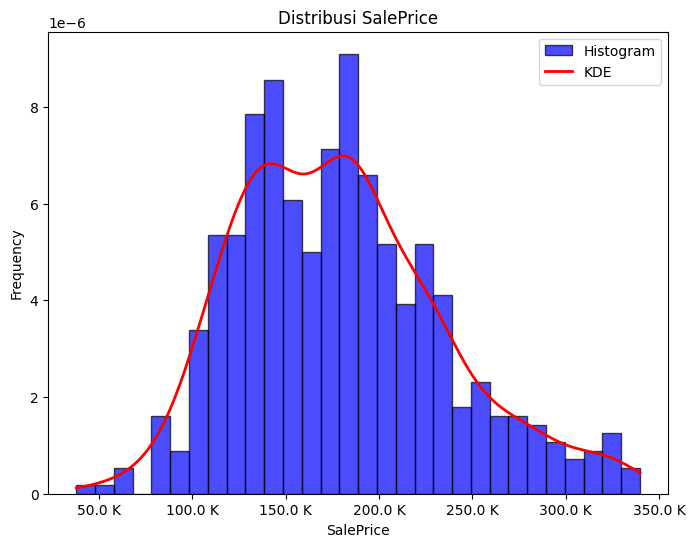

In [48]:
# Histogram Distribusi
plt.figure(figsize = (8, 6))
plt.hist(y_train, bins = 30, color = 'blue', alpha = 0.7, edgecolor = 'black', density = True, label = 'Histogram')

# Menambahkan KDE (Kernel Density Estimation)
kde = gaussian_kde(y_train)
x_vals = np.linspace(y_train.min(), y_train.max(), 1000)
kde_vals = kde(x_vals)
plt.plot(x_vals, kde_vals, color = 'red', linewidth = 2, label = 'KDE')

#
plt.title('Distribusi SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Mengatur formatter untuk sumbu x dan y
formatter = ticker.FuncFormatter(lab_round)
plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()

# 4. Menampilkan Plot
plt.show()

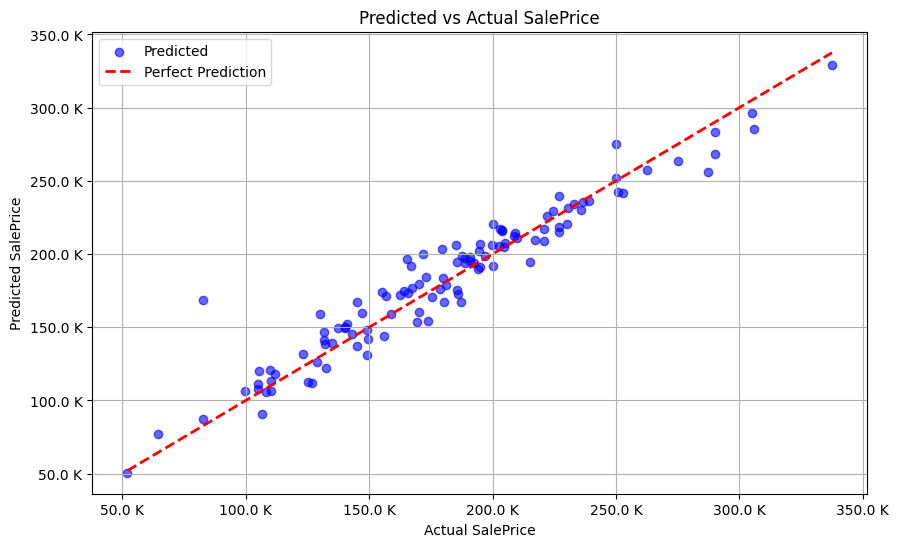

In [49]:
# Membuat scatter plot
plt.figure(figsize = (10, 6))
plt.scatter(y_valid, y_valid_pred, alpha = 0.6, color = 'blue', label = 'Predicted')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw = 2, label = 'Perfect Prediction')

plt.title('Predicted vs Actual SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')

# Mengatur formatter untuk sumbu x dan y
formatter = ticker.FuncFormatter(lab_round)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()
plt.grid()

plt.show()